# Import all required libraries

In [1]:
import nltk
import numpy as np
import re
import pandas as pd 
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from textblob import TextBlob
from sklearn.cluster import KMeans
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#!pip install datashader
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
%matplotlib inline


C:\New folder\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\New folder\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


#### Load the dataset and take a look at the first few records

In [2]:
df = pd.read_csv('London_hotel_reviews.csv', encoding = "ISO-8859-1")
print(df.shape)
df.head()

(27330, 6)


,Property_Name,Review_Rating,Review_Title,Review_Text,Location_Of_The_Reviewer,Date_Of_Review
0,Apex London Wall Hotel,5,Ottima qualità prezzo,Siamo stati a Londra per un week end ed abbiam...,"Casale Monferrato, Italy",10/20/2012
1,Corinthia Hotel London,5,"By far, my best hotel in the world",I had a pleasure of staying in this hotel for ...,"Savannah, Georgia",3/23/2016
2,The Savoy,5,First visit to the American Bar at the Savoy,A very lovely first visit to this iconic hotel...,London,7/30/2013
3,Rhodes Hotel,4,Nice stay,3 of us stayed at the Rhodes Hotel for 4 night...,"Maui, Hawaii",06-02-2012
4,The Savoy,5,Perfection,Form the moment we arrived until we left we ex...,"London, United Kingdom",11/24/2017


In [3]:
print(df.isna().sum(), end = '\n\n')
df[df.isnull().any(axis=1)].head()

Property_Name                  0
Review_Rating                  0
Review_Title                   0
Review_Text                    0
Location_Of_The_Reviewer    3953
Date_Of_Review                 1
dtype: int64



,Property_Name,Review_Rating,Review_Title,Review_Text,Location_Of_The_Reviewer,Date_Of_Review
5,Corinthia Hotel London,1,Staff stole from me!!,Well I am no strange to London's 5star hotels ...,NaN,03-01-2013
24,Mondrian London at Sea Containers,5,"Fantastic nights stay, one of the best hotels ...",My partner and I found this hotel by chance an...,NaN,6/20/2015
34,Mondrian London at Sea Containers,5,Just as good second time around!,After an amazing experience the first time we ...,NaN,10/15/2015
37,The Rembrandt,5,Good Hotel - Great Area,Very good hotel in a lovely area. Handy to the...,NaN,11-04-2016
45,Apex London Wall Hotel,4,Eccellente,"In tutto, dalla struttura nuova in stile moder...",NaN,4/30/2013


In [4]:
df[df["Date_Of_Review"].isnull()]

,Property_Name,Review_Rating,Review_Title,Review_Text,Location_Of_The_Reviewer,Date_Of_Review
6556,The Lanesborough,4,<U+0412> <U+043F><U+043E><U+0434><U+0440><U+04...,<U+041E><U+0442><U+0435><U+043B><U+044C> : | <...,NaN,NaN


In [5]:
print(len(df[df['Review_Title'].str.contains("<U")]), 'reviews that are probably gibberish.')
df[df['Review_Title'].str.contains("<U")].head()

431 reviews that are probably gibberish.


,Property_Name,Review_Rating,Review_Title,Review_Text,Location_Of_The_Reviewer,Date_Of_Review
90,The Dorchester,5,<U+0391><U+03B3><U+03B3><U+03BB><U+03B9><U+03B...,e<U+03B9><U+03BD>a<U+03B9> e<U+03BD>a<U+03C2> ...,"Athens, Greece",7/18/2017
174,Corinthia Hotel London,5,<U+041B><U+0443><U+0447><U+0448><U+0438><U+043...,<U+0423><U+0440><U+043E><U+0432><U+0435><U+043...,Zurich,2/17/2016
178,"Mandarin Oriental Hyde Park, London",5,<U+512A><U+96C5><U+306A><U+6642><U+9593><U+304...,<U+5148><U+6708><U+3001><U+304A><U+98DF><U+4E8...,"Aichi Prefecture, Japan",11/20/2015
328,The Savoy,5,<U+C544><U+B984><U+B2F5><U+ACE0> <U+C6B0><U+C5...,<U+CE5C><U+C808><U+D558><U+ACE0> <U+C720><U+CF...,NaN,5/15/2017
364,45 Park Lane - Dorchester Collection,5,<U+041C><U+043E><U+0434><U+043D><U+044B><U+043...,<U+041E><U+0442><U+0435><U+043B><U+044C> <U+04...,"Moscow, Russia",09-01-2015


In [6]:
df = df[df['Review_Title'].str.contains("<U") == False]

In [7]:
print(df.shape)
df.head()

(26899, 6)


,Property_Name,Review_Rating,Review_Title,Review_Text,Location_Of_The_Reviewer,Date_Of_Review
0,Apex London Wall Hotel,5,Ottima qualità prezzo,Siamo stati a Londra per un week end ed abbiam...,"Casale Monferrato, Italy",10/20/2012
1,Corinthia Hotel London,5,"By far, my best hotel in the world",I had a pleasure of staying in this hotel for ...,"Savannah, Georgia",3/23/2016
2,The Savoy,5,First visit to the American Bar at the Savoy,A very lovely first visit to this iconic hotel...,London,7/30/2013
3,Rhodes Hotel,4,Nice stay,3 of us stayed at the Rhodes Hotel for 4 night...,"Maui, Hawaii",06-02-2012
4,The Savoy,5,Perfection,Form the moment we arrived until we left we ex...,"London, United Kingdom",11/24/2017


#### Number of unique Reviews.

In [8]:
unique_text = df.Review_Text.unique()
print(len(unique_text))

26898


#### Number of Unique Locations


In [9]:
unique_location = df.Location_Of_The_Reviewer.unique()
len(unique_location)
df.Location_Of_The_Reviewer.value_counts().head(20) 

London, United Kingdom         1848
London                          469
New York City, New York         308
Paris, France                   216
Manchester, United Kingdom      193
Sydney, Australia               154
Los Angeles, California         144
Melbourne, Australia            142
UK                              138
Birmingham, United Kingdom      129
Toronto, Canada                 116
Edinburgh, United Kingdom       102
Milan, Italy                    101
Dublin, Ireland                  96
Glasgow, United Kingdom          95
Hong Kong, China                 95
Bristol, United Kingdom          93
Leeds, United Kingdom            88
Singapore, Singapore             88
Dubai, United Arab Emirates      85
Name: Location_Of_The_Reviewer, dtype: int64

#### Text Cleaning

In [10]:
df.Review_Text.count()

26899

In [11]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

#### Remove special characters, numbers, punctuations

#### And creat a new column Clean_text.

In [12]:
df['Clean_text'] = df['Review_Text'].str.replace("[^a-zA-Z#]", " ")

In [13]:

df['Clean_text'] = df['Clean_text'].str.replace("[^a-zA-Z#]", " ")

In [14]:
df['Clean_text'] = df['Clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [15]:
tokenized_text = df['Clean_text'].apply(lambda x: x.split())

In [16]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_text.head()

0    [siamo, stati, londra, week, abbiamo, alloggia...
1    [pleasur, stay, thi, hotel, night, recent, thi...
2    [veri, love, first, visit, thi, icon, hotel, w...
3    [stay, rhode, hotel, night, great, locat, take...
4    [form, moment, arriv, until, left, experienc, ...
Name: Clean_text, dtype: object

#### Compair Review_Test and Clean_Test

In [17]:
df.loc[:,('Review_Text','Clean_text')]

,Review_Text,Clean_text
0,Siamo stati a Londra per un week end ed abbiam...,Siamo stati Londra week abbiamo alloggiato que...
1,I had a pleasure of staying in this hotel for ...,pleasure staying this hotel nights recently Th...
2,A very lovely first visit to this iconic hotel...,very lovely first visit this iconic hotel Wond...
3,3 of us stayed at the Rhodes Hotel for 4 night...,stayed Rhodes Hotel nights great location taki...
4,Form the moment we arrived until we left we ex...,Form moment arrived until left experienced abs...
5,Well I am no strange to London's 5star hotels ...,Well strange London star hotels when comes alo...
6,"The hotel staff were very helpful, I booked th...",hotel staff were very helpful booked wrong hot...
7,Already stepping out of the taxi you get that ...,Already stepping taxi that very special feelin...
8,What an incredibly cool place. Had the most de...,What incredibly cool place most delicious inte...
9,"Ottimo rapporto qualità - prezzo, ottima la po...",Ottimo rapporto qualit prezzo ottima posizione...


 #### Check to Null or Missing Values present in Review_Test column.

In [18]:
df[df.Review_Text.isnull()]

,Property_Name,Review_Rating,Review_Title,Review_Text,Location_Of_The_Reviewer,Date_Of_Review,Clean_text


 #### Check to Null or Missing Values present in Review_Test column.

In [19]:
df[df.Clean_text.isnull()]

,Property_Name,Review_Rating,Review_Title,Review_Text,Location_Of_The_Reviewer,Date_Of_Review,Clean_text


There is no missing value in the above both columns.

#### Number of unique Review

In [20]:
unique_clean_text = df.Clean_text.unique()
unique_full_text = df.Review_Text.unique()
print(len(unique_clean_text))
print(len(unique_full_text))
print(len(df))


26890
26898
26899


In [21]:
df.drop_duplicates(subset=['Clean_text'], keep = 'first',inplace= True)

In [22]:
df.reset_index(drop=True,inplace=True)

In [23]:
df['Clean_text_length'] = df['Clean_text'].apply(len)
df.head()

,Property_Name,Review_Rating,Review_Title,Review_Text,Location_Of_The_Reviewer,Date_Of_Review,Clean_text,Clean_text_length
0,Apex London Wall Hotel,5,Ottima qualità prezzo,Siamo stati a Londra per un week end ed abbiam...,"Casale Monferrato, Italy",10/20/2012,Siamo stati Londra week abbiamo alloggiato que...,829
1,Corinthia Hotel London,5,"By far, my best hotel in the world",I had a pleasure of staying in this hotel for ...,"Savannah, Georgia",3/23/2016,pleasure staying this hotel nights recently Th...,994
2,The Savoy,5,First visit to the American Bar at the Savoy,A very lovely first visit to this iconic hotel...,London,7/30/2013,very lovely first visit this iconic hotel Wond...,258
3,Rhodes Hotel,4,Nice stay,3 of us stayed at the Rhodes Hotel for 4 night...,"Maui, Hawaii",06-02-2012,stayed Rhodes Hotel nights great location taki...,312
4,The Savoy,5,Perfection,Form the moment we arrived until we left we ex...,"London, United Kingdom",11/24/2017,Form moment arrived until left experienced abs...,272


#### Looks like these are Review with different languages or just hastags.


In [24]:
df[df['Clean_text_length']==0]['Clean_text'] 

list = df[df['Clean_text_length']==0]['Clean_text'].index
list

Int64Index([257], dtype='int64')

#### We can simply drop these Reviews.

In [25]:
df.drop(index = list,inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26889 entries, 0 to 26889
Data columns (total 8 columns):
Property_Name               26889 non-null object
Review_Rating               26889 non-null int64
Review_Title                26889 non-null object
Review_Text                 26889 non-null object
Location_Of_The_Reviewer    23054 non-null object
Date_Of_Review              26889 non-null object
Clean_text                  26889 non-null object
Clean_text_length           26889 non-null int64
dtypes: int64(2), object(6)
memory usage: 1.8+ MB


In [27]:
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26889 entries, 0 to 26888
Data columns (total 8 columns):
Property_Name               26889 non-null object
Review_Rating               26889 non-null int64
Review_Title                26889 non-null object
Review_Text                 26889 non-null object
Location_Of_The_Reviewer    23054 non-null object
Date_Of_Review              26889 non-null object
Clean_text                  26889 non-null object
Clean_text_length           26889 non-null int64
dtypes: int64(2), object(6)
memory usage: 1.6+ MB


#### Calculate Sentiment Analyser

In [28]:
from textblob import TextBlob

In [29]:
def calculate_sentiment(Clean_text):
    return TextBlob(Clean_text).sentiment

In [30]:
def calculate_sentiment_analyser(Clean_text):    
    return analyser.polarity_scores(Clean_text)

In [31]:
df['sentiment']=df.Clean_text.apply(calculate_sentiment)
df['sentiment_analyser']=df.Clean_text.apply(calculate_sentiment_analyser)
s = pd.DataFrame(index = range(0,len(df)),columns= ['compound_score','compound_score_sentiment'])
for i in range(0,len(df)): 
  s['compound_score'][i] = df['sentiment_analyser'][i]['compound']
  
  if (df['sentiment_analyser'][i]['compound'] <= -0.05):
    s['compound_score_sentiment'][i] = 'Negative'    
  if (df['sentiment_analyser'][i]['compound'] >= 0.05):
    s['compound_score_sentiment'][i] = 'Positive'
  if ((df['sentiment_analyser'][i]['compound'] >= -0.05) & (df['sentiment_analyser'][i]['compound'] <= 0.05)):
    s['compound_score_sentiment'][i] = 'Neutral'
    
df['compound_score'] = s['compound_score']
df['compound_score_sentiment'] = s['compound_score_sentiment']
df.head()

,Property_Name,Review_Rating,Review_Title,Review_Text,Location_Of_The_Reviewer,Date_Of_Review,Clean_text,Clean_text_length,sentiment,sentiment_analyser,compound_score,compound_score_sentiment
0,Apex London Wall Hotel,5,Ottima qualità prezzo,Siamo stati a Londra per un week end ed abbiam...,"Casale Monferrato, Italy",10/20/2012,Siamo stati Londra week abbiamo alloggiato que...,829,"(0.05833333333333335, 0.45)","{'neg': 0.035, 'neu': 0.948, 'pos': 0.017, 'co...",-0.4404,Negative
1,Corinthia Hotel London,5,"By far, my best hotel in the world",I had a pleasure of staying in this hotel for ...,"Savannah, Georgia",3/23/2016,pleasure staying this hotel nights recently Th...,994,"(0.2735902255639098, 0.4983709273182957)","{'neg': 0.041, 'neu': 0.826, 'pos': 0.133, 'co...",0.9336,Positive
2,The Savoy,5,First visit to the American Bar at the Savoy,A very lovely first visit to this iconic hotel...,London,7/30/2013,very lovely first visit this iconic hotel Wond...,258,"(0.41818181818181815, 0.6542929292929293)","{'neg': 0.0, 'neu': 0.602, 'pos': 0.398, 'comp...",0.9575,Positive
3,Rhodes Hotel,4,Nice stay,3 of us stayed at the Rhodes Hotel for 4 night...,"Maui, Hawaii",06-02-2012,stayed Rhodes Hotel nights great location taki...,312,"(0.3642708333333333, 0.58875)","{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compou...",0.9729,Positive
4,The Savoy,5,Perfection,Form the moment we arrived until we left we ex...,"London, United Kingdom",11/24/2017,Form moment arrived until left experienced abs...,272,"(0.4335714285714286, 0.6271428571428571)","{'neg': 0.0, 'neu': 0.65, 'pos': 0.35, 'compou...",0.9531,Positive


#### Export the data with sentiment.

In [32]:
df.to_csv('E:\Work From Home\Text mining project.csv')

#### Sentiment Score with Positive, Neutral and Negative.

In [33]:
plot_size=plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])

plot_size[0]=8
plot_size[1]=6
plot_size=plt.rcParams["figure.figsize"]

6.0
4.0


In [34]:
df.compound_score_sentiment.value_counts()

Positive    23960
Neutral      1997
Negative      932
Name: compound_score_sentiment, dtype: int64

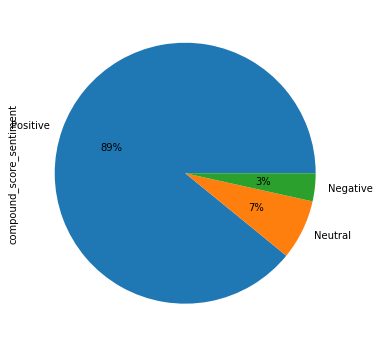

In [35]:
df.compound_score_sentiment.value_counts().plot(kind='pie',autopct='%1.0f%%')

We can see the above pie chart the mostly review text 89% positive sentiment, second neutral is 7% and 3% negative sentiment of London restaurants review.

In [36]:
df['Clean_text'].head()

0    Siamo stati Londra week abbiamo alloggiato que...
1    pleasure staying this hotel nights recently Th...
2    very lovely first visit this iconic hotel Wond...
3    stayed Rhodes Hotel nights great location taki...
4    Form moment arrived until left experienced abs...
Name: Clean_text, dtype: object

#### TF-IDE

In [37]:
from sklearn.cluster import KMeans

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# Considering 3 grams and mimnimum frq as 0
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
tf_idf_vect.fit(df['Clean_text'])
desc_matrix = tf_idf_vect.transform(df["Clean_text"])

## Implement kmeans

In [39]:
from sklearn.cluster import KMeans
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

#### Create DataFrame films from all of the input files.

In [40]:
Review = {'Review': df["Clean_text"].tolist(), 'Cluster': clusters}
frame = pd.DataFrame(Review, index = [clusters])
frame.head()

,Review,Cluster
1,Siamo stati Londra week abbiamo alloggiato que...,1
2,pleasure staying this hotel nights recently Th...,2
1,very lovely first visit this iconic hotel Wond...,1
1,stayed Rhodes Hotel nights great location taki...,1
1,Form moment arrived until left experienced abs...,1


#### Value Count with individual Cluster.

In [41]:
frame['Cluster'].value_counts()

1    18282
2     7556
0     1051
Name: Cluster, dtype: int64

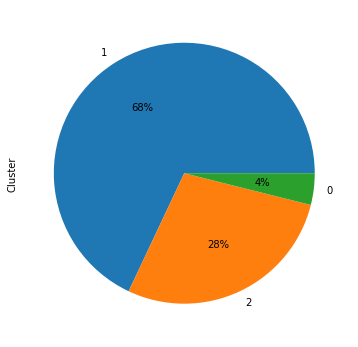

In [42]:
frame.Cluster.value_counts().plot(kind='pie',autopct='%1.0f%%')

In [43]:
frame[frame['Cluster'] == 1]

,Review,Cluster
1,Siamo stati Londra week abbiamo alloggiato que...,1
1,very lovely first visit this iconic hotel Wond...,1
1,stayed Rhodes Hotel nights great location taki...,1
1,Form moment arrived until left experienced abs...,1
1,hotel staff were very helpful booked wrong hot...,1
1,Already stepping taxi that very special feelin...,1
1,What incredibly cool place most delicious inte...,1
1,Ottimo rapporto qualit prezzo ottima posizione...,1
1,Savoy Savoy every time came back real surprise...,1
1,looking forward staying here high expections w...,1


In [44]:
frame[frame['Cluster'] == 2]

,Review,Cluster
2,pleasure staying this hotel nights recently Th...,2
2,Well strange London star hotels when comes alo...,2
2,location next park close Harvey Harrods means ...,2
2,booked night choosing this hotel close Barbica...,2
2,Well what chose this venue propose girlfriend ...,2
2,Mandarin London lives five star rating that de...,2
2,Nice visit didn feel special Upgraded superior...,2
2,partner found this hotel chance good reviews c...,2
2,have just returned from very quick trip London...,2
2,always little skeptical about what read glowin...,2


In [45]:
features = frame.iloc[:, 0].values
labels = frame.iloc[:, 1].values

In [46]:
Processed_features = []
for sentence in range(0,len(features)):
    # Remove all the special characters 
    processed_feature = re.sub(r'\W',' ',str(features[sentence]))
    
    # Remove all single characters
    precessed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ',  processed_feature)
    
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ',  processed_feature)
    
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ',  processed_feature, flags=re.I)
    
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    
    # Converting to Lowercase
    processed_feature = processed_feature.lower()
    
    Processed_features.append(processed_feature)

### Fit the Random Forest Classification Model . 

In [47]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
Processed_features = vectorizer.fit_transform(Processed_features).toarray()

#### Split the data into two parts Training set and test set.

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Processed_features, labels, test_size=0.2, random_state=0)


## Train the model with Random Forest Classifier with sentiment 

In [49]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Predicting the Test set results

In [50]:
predictions = text_classifier.predict(X_test)

#### Making the Confusion Matrix with Accuracy

In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print('accuracy score', accuracy_score(y_test, predictions))

[[  26    0  168]
 [   0 3614   69]
 [   0  422 1079]]
accuracy score 0.8774637411677203


## Sentiment Analysis with Random Forest Classifier.

Review Text contain many slang words and punctuation marks. We need to clean our review texts before they can be user for training the machine learning model. However, before cleaning the raview test, let's divide our dataset into feature and label sets.

Our feature set will consist of raview text only. If we look at our dataset 4th column contain review text. Note that the index of the column will be 3 sence pandas columns follow zero-based indexing scheme where the first column is called 0th column. Our lable set will consist of the sentiment of the review text that we have to predict. The sentiment of the review is in the second column (index 1). To create a feature and a label set we can use the iloc method off the pandas data frame.

In [52]:
features = df.iloc[:, 3].values
labels = df.iloc[:, 1].values

In [53]:
features = df.iloc[:, 3].values

In [54]:
Processed_features = []
for sentence in range(0,len(features)):
    # Remove all the special characters 
    processed_feature = re.sub(r'\W',' ',str(features[sentence]))
    
    # Remove all single characters
    precessed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ',  processed_feature)
    
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ',  processed_feature)
    
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ',  processed_feature, flags=re.I)
    
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    
    # Converting to Lowercase
    processed_feature = processed_feature.lower()
    
    Processed_features.append(processed_feature)

## TF-IDF

 In the bag of words approach, each word has the same weight. The idea behaind the TF-IDF approach is that the words that accure less in all the ducumnets and more in individual document contribute more towords classification. 

### TF-IDF is a combination of two terms. Term frequency can be calculated as:

TF = (Frequency of a word in the document)/(Total words in the document)

 IDF = log((Total number of docs)/(Number of docs containing the word))

### TF-IDF using the Scikit-Learn Library

Luckily for us, Python's Scikit-Learn library contains the TfidVectorized class that can be used to convert text features into TF-IDF feature vectors. The following script performs this: 

In [55]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
Processed_features = vectorizer.fit_transform(Processed_features).toarray()

In the above code, we define that the max_features should be 2500, which means that it only uses the 2500 most frequently occuring words to create a bag of words feature vector. words that occur less frequently are not very useful for classification.

Similarly, max_df specifies that only use those words that occure in maximum of 80% of the documents. Words that occur in all documents are too common and are not very useful for classification. Similarly, min_df is set to 7 which shows that include words that occur in at least 7 documents.


## Dividing Data into Training and Test sets

In the previous section, we converted the data into the numeric from. As the last step before we train our algorithms, we need to divide our data into training and test sets. The training set will be used to train the algorithm while the test set will be used to evaluate the performance of the machine learning model.

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Processed_features, labels, test_size=0.2, random_state=0)


## Train the Random Forest Classification model on the Training set

In [57]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Predicting the Test set results

In [58]:
predictions = text_classifier.predict(X_test)

## Making the Confusion Matrix with Accuracy

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print('accuracy score', accuracy_score(y_test, predictions))

[[   9    0    3   19   98]
 [   1    0    4   26  102]
 [   0    0    2   88  232]
 [   0    0    1  194  990]
 [   0    0    0   77 3532]]
accuracy score 0.6948679806619561


## Sentiment Analysis with Binary Logistic Classification for Goods & Bad Reviews.

Now that we have a good handle on the data, we can try to make a simple model that can take the text of a review and predict from that what rating was given. To keep it simple for the model I'll divide reviews into good and bad, with "good" being a 5 star review and bad being anything below. 

In [60]:
df['Complete_Review'] = df['Review_Title'] + ' ' + df['Review_Text']
df.loc[df['Review_Rating'] > 4, 'Good_Review'] = 1
df.loc[df['Review_Rating'] <= 4, 'Good_Review'] = 0
print(sum(df['Good_Review'] == 0) / len(df['Good_Review']) * 100, 'percent of reviews are bad (less than 5 star).')

32.887054185726505 percent of reviews are bad (less than 5 star).


Next to make a train and test set, with 80% of the data being the train set and 20% being the test set. The model will be trained on the training data and evaluated on the test data.

In [61]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

Before feeding reviews into a model, they should be cleaned to remove punctuation, as that willl be useless from the computers point of view in trying to work out the sentiment of a text - for this case we're only interested in the words in a review. The code below (from https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184) gets rid of punctuation so a review is turned into words only.

In [62]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(train['Complete_Review'])
reviews_test_clean = preprocess_reviews(test['Complete_Review'])

The next step is *one hot encoding*, where we turn each review into a very large matrix of 0's and 1's. A 0 would represent a certain word isn't included, whereas a 1 means that word is included. A short review of a few words would have a matrix of almost entirely 0's (ie. the vast majority of unique words across all reviews aren't present in the review), with just a small number of 1's. This is necessary for the logistic regression algorithm used below.

In [63]:
cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X_train = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

Now we can finally train a model on the train data with model.fit(). After that, model.predict() can be called on the test data to evaluate how good the model does. We know around 67% of reviews are 5 stars, so as a naive benchmark, we'd expect the model to predict the right rating based on the review text over 67% of the time.

## Train the model with Binary Logistic Classification model.

In [64]:
target_train = train['Good_Review']
target_test = test['Good_Review']

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, target_train)

C:\New folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Predicting the test set results.

In [65]:
predictions = model.predict(X_test)

### Making the Confusion Matrix with Accuracy

In [66]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(target_test,predictions))
print('accuracy score', accuracy_score(target_test, predictions))

[[1227  571]
 [ 455 3191]]
accuracy score 0.8115356355620867


With over 81% accuracy, this is a reasonable model in that it clearly beats the naive baseline that merely guesses the most likely rating (5 stars - good) for each review, though it could be improved as I haven't done any tweaking.

Finally, it's interesting to see what words the model considers good and bad, 

In [67]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), model.coef_[0]
    )
}
print('Good words:', end = "\n\n")
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
print('')
print('Bad words:', end = "\n\n")
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

Good words:

('glazed', 1.64947294902261)
('lcd', 1.4132304520624548)
('meets', 1.3551980995807569)
('pancras', 1.3458214409823865)
('disappoints', 1.3111416141045602)

Bad words:

('lacked', -1.819011515452316)
('lacking', -1.7766100578243256)
('backwards', -1.7367878885347694)
('cris', -1.6830882411797827)
('spite', -1.6366732707124838)


# Thank You 